In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm.notebook import tqdm

In [8]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import lax

from functools import partial

key = random.PRNGKey(0)

In [10]:
dataset = []
for path in tqdm(os.listdir('/content/drive/MyDrive/Dataset/')):
    image = nib.load('/content/drive/MyDrive/Dataset/'+path)
    dataset.append(np.array(image.get_fdata())[:,:,:,0]/np.array(image.get_fdata())[:,:,:,0].max())

dataset = np.array(dataset)

In [11]:
def gridInterval(img,k):
    #Number of Pixels
    N = img.shape[0]*img.shape[1]*img.shape[2]
    #Average Area of the Supervoxels
    ratio = N/k
    #Distance between centers
    S = (ratio)**(1/3)
    
    return int(S)

In [12]:
class SuperVoxel():
    '''Class to represent a supervoxel'''
    def __init__(self,intensity,x,y,z):
        self.i = intensity
        self.x = x
        self.y = y
        self.z = z
        self.coord = np.array((x,y,z))
        self.voxels = {}
        
    def update(self,intensity,x,y,z):
        self.i = intensity
        self.x = x
        self.y = y
        self.z = z
        self.coord = np.array((x,y,z))

    def describe(self):
        print("Coordinates: ",self.coord," Intensity: ",self.i, " Voxel Count: ",self.voxels.sum())
      
        
def createSuperVoxel(x,y,z,image):
    '''Function to return a SuperVoxel object'''
    return SuperVoxel(image[x,y,z],x,y,z)

def updateSuperVoxel(voxel,x,y,z,image):
    return voxel.update(image[x,y,z],x,y,z)

In [13]:
# To define the initial cluster centers distanced at S
def initialClusterCenter(S,img,img_h,img_w,img_d,clusters):
    h = S // 3
    w = S // 3
    d = S // 3
    while h < img_h:
        while w < img_w:
            while d < img_d:
                clusters.append(createSuperVoxel(int(h), int(w), int(d), img))
                d += S
            d = S // 3
            w += S
        w = S // 3
        h += S
    
    #Returning clusters
    return clusters

In [14]:
def getGradient(h,w,d,img_h,img_w,img_d,img):
    #Checking for out of bounds
    if w+1 >= img_w:
        w = img_w - 2
    if h+1 >= img_h:
        h = img_h - 2
    if d+1 >= img_d:
        d = img_d - 2
    
    #Using sq-gradient formula
    gradient = (img[h+1,w,d] - img[h-1,w,d])**2 + (img[h,w+1,d] - img[h,w-1,d])**2 + (img[h,w,d+1] - img[h,w,d-1])**2
    
    #returning value
    return gradient

def reassignwGradient(clusters,img):
    #count = 0
    MH, MW, MD = img.shape[0],img.shape[1],img.shape[2]
    MH_1, MW_1, MD_1 = MH-1, MW-1, MD-1
    for c in clusters:
        #count += 1
        c_gradient = getGradient(c.x,c.y,c.z,MH, MW, MD,img)
        
        for dh in range(-1,2):
            for dw in range(-1,2):
                for dd in range(-1,2):
                    H = min(c.x + dh, MH_1)
                    W = min(c.y + dw, MW_1)
                    D = min(c.z + dd, MD_1)

                    n_gradient = getGradient(H,W,D,MH, MW, MD,img)
                
                    if n_gradient < c_gradient:
                        #Update to the smaller gradient voxel
                        #print("On cent",count,"Reassigned",c.x,c.y,c.z,"to",H,W,D)
                        
                        updateSuperVoxel(c,H,W,D,img)
                        c_gradient = n_gradient

In [15]:
@jit
def calculateVoxelDistance(voxel_i,voxel_coord,img,x,y,z,S,l):
    #calculating D_ij(in)
    i = img[x,y,z]
    d_in = jnp.sqrt((voxel_i - i)**2)
    
    #Calculating D_ij(sp)
    d_sp = jnp.linalg.norm(voxel_coord - jnp.array((x,y,z)))
    
    #Calculating final distance
    D = jnp.sqrt(
        (d_in/l)**2 + (d_sp/S)**2
    )
    return D

In [16]:
@jit
def cvd_z(i, coord, img, h,w,rz, S,l):
    return vmap(calculateVoxelDistance, in_axes=[None, None, None, None, None, 0, None, None])(i, coord, img, h,w,rz, S,l)

@jit
def cvd_y(i, coord, img, h,ry,rz, S,l):
    return vmap(cvd_z, in_axes=[None, None, None, None, 0, None, None, None])(i, coord, img, h,ry,rz, S,l)

@jit
def cvd_x(i, coord, img, rx,ry,rz, S,l):
    return vmap(cvd_y, in_axes=[None, None, None, 0, None, None, None, None])(i, coord, img, rx,ry,rz, S,l)

In [17]:
from itertools import product

In [18]:
def assignVoxels(clusters,S,l,img,tag,dis):
    '''
    To assign cluster voxels to the centroids
    '''
    
    #Taking the image coordinates
    img_h = img.shape[0]
    img_w = img.shape[1]
    img_d = img.shape[2]
    
    img = jnp.asarray(img)
    dds = np.zeros_like(dis)

    for c in tqdm(clusters):
        rgx = range(max(c.x - 2*S, 0), min(c.x + 2*S, img_h))
        rgy = range(max(c.y - 2*S, 0), min(c.y + 2*S, img_w))
        rgz = range(max(c.z - 2*S, 0), min(c.z + 2*S, img_d))
        rx = np.asarray(rgx)
        ry = np.asarray(rgy)
        rz = np.asarray(rgz)
        
        distance = cvd_x(c.i, c.coord, img, rx,ry,rz, S,l)
        ox, oy, oz = rgx.start, rgy.start, rgz.start
        ex, ey, ez = rgx.stop, rgy.stop, rgz.stop
        dds[ox:ex,oy:ey,oz:ez] = np.asarray(distance)
        for h,w,d in product(rgx, rgy, rgz):
            #Reassignment
            curd = dds[h, w, d]
            if curd < dis[h,w,d]:
                key = (h,w,d)
                if key in tag:
                    tag[key].voxels.pop(key,None)
                tag[key] = c
                c.voxels[key] = None

                dis[h,w,d] = curd

In [19]:
def updateCentroids(clusters,img):
    img = np.asarray(img)
    for c in tqdm(clusters):
        sum_h = sum_w = sum_d = number = 0
        for p in c.voxels.keys():
            #Sum of values
            sum_h += p[0]
            sum_w += p[1]
            sum_d += p[2]
            number += 1
            
            #Taking the mean
            H = sum_h // number
            W = sum_w // number
            D = sum_d // number
            
            #Updating voxel
            updateSuperVoxel(c,H,W,D,img)

In [20]:
def runSlic(img,k,l):
    #Initialing arguments
    S = gridInterval(img,k)
    img_h = img.shape[0]
    img_w = img.shape[1]
    img_d = img.shape[2]
    
    #History 
    tag = dict()
    dis = np.full((img_h, img_w, img_d), np.inf)
    
    clusters = initialClusterCenter(S,img,img_h,img_w,img_d,[])
    reassignwGradient(clusters,img)
    for i in range(10):
        try:
            #Reassignment
            print(f"On iteraion {i+1}")
            assignVoxels(clusters,S,l,img,tag,dis)
            updateCentroids(clusters,img)
        except Exception as e:
            print("Loop Broken:",e)
            break

    return clusters,tag,dis

In [21]:
def imageConvert(img,clusters):
    image = np.asarray(img)
    for c in tqdm(clusters):
        for x,y,z in c.voxels:
            image[x,y,z]=c.i
    return image

In [24]:
import pickle
import gc

In [ ]:
i = 0
for d in dataset:
    i += 1
    print("Image ",i)
    clusters,tag,dis = runSlic(d,12000,50)
    gc.collect()
    print("Saving ",i,"\n")
    with open(f"/content/drive/MyDrive/Clusters/clusters_{i}.pkl", "wb") as f:
        pickle.dump(clusters, f)

Image  1
On iteraion 1



On iteraion 2



On iteraion 3



On iteraion 4



On iteraion 5



On iteraion 6



On iteraion 7



On iteraion 8



On iteraion 9



On iteraion 10



Saving  1 

Image  2
On iteraion 1



On iteraion 2



On iteraion 3



On iteraion 4



On iteraion 5



On iteraion 6



On iteraion 7



On iteraion 8



On iteraion 9



On iteraion 10



Saving  2 

Image  3
On iteraion 1



On iteraion 2



On iteraion 3



On iteraion 4



On iteraion 5



On iteraion 6



On iteraion 7



On iteraion 8



On iteraion 9



On iteraion 10



Saving  3 

Image  4
On iteraion 1



On iteraion 2



On iteraion 3



On iteraion 4



On iteraion 5



On iteraion 6



On iteraion 7



On iteraion 8



On iteraion 9



On iteraion 10



Saving  4 

Image  5
On iteraion 1



On iteraion 2



On iteraion 3



On iteraion 4



On iteraion 5



On iteraion 6



On iteraion 7



On iteraion 8



On iteraion 9



On iteraion 10



Saving  5 

Image  6
On iteraion 1



On iteraion 2



On iteraion 3



On iteraion 4



On iteraion 5



On iteraion 6



On iteraion 7



On iteraion 8



On iteraion 9



On iteraion 10



Saving  6 

Image  7
On iteraion 1



On iteraion 2



On iteraion 3



On iteraion 4



On iteraion 5



On iteraion 6



On iteraion 7



On iteraion 8



On iteraion 9



On iteraion 10



Saving  7 

Image  8
On iteraion 1



On iteraion 2



On iteraion 3



On iteraion 4



On iteraion 5



On iteraion 6



On iteraion 7



On iteraion 8



On iteraion 9



On iteraion 10



Saving  8 

Image  9
On iteraion 1



On iteraion 2



On iteraion 3



On iteraion 4



On iteraion 5



On iteraion 6



On iteraion 7



On iteraion 8



On iteraion 9



On iteraion 10



Saving  9 

Image  10
On iteraion 1



On iteraion 2



On iteraion 3



On iteraion 4



On iteraion 5



On iteraion 6



On iteraion 7



On iteraion 8



On iteraion 9



On iteraion 10



Saving  10 

Image  11
On iteraion 1



On iteraion 2



On iteraion 3



On iteraion 4



On iteraion 5



On iteraion 6



On iteraion 7



On iteraion 8



On iteraion 9



On iteraion 10



Saving  11 

Image  12
On iteraion 1



On iteraion 2



On iteraion 3



On iteraion 4



On iteraion 5



On iteraion 6



On iteraion 7



On iteraion 8



On iteraion 9



On iteraion 10



Saving  12 

Image  13
On iteraion 1



On iteraion 2



On iteraion 3



On iteraion 4



On iteraion 5



On iteraion 6



On iteraion 7



On iteraion 8



On iteraion 9



On iteraion 10



Saving  13 

Image  14
On iteraion 1



On iteraion 2



On iteraion 3



On iteraion 4



On iteraion 5



On iteraion 6



On iteraion 7



On iteraion 8



On iteraion 9



On iteraion 10



Saving  14 

Image  15
On iteraion 1



On iteraion 2



On iteraion 3



On iteraion 4



On iteraion 5



On iteraion 6



On iteraion 7



On iteraion 8



On iteraion 9



On iteraion 10



Saving  15 

Image  16
On iteraion 1



On iteraion 2



On iteraion 3



On iteraion 4



On iteraion 5



On iteraion 6



On iteraion 7



On iteraion 8



On iteraion 9



On iteraion 10



Saving  16 

Image  17
On iteraion 1



On iteraion 2



On iteraion 3



On iteraion 4



On iteraion 5



On iteraion 6



On iteraion 7



On iteraion 8



On iteraion 9



On iteraion 10


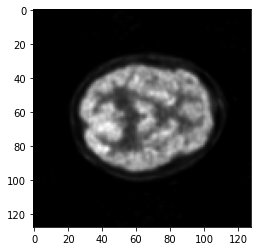

In [ ]:
plt.imshow(test[:,:,32],cmap='gray')
plt.show()

In [ ]:
converted = imageConvert(test,clusters)

  0%|          | 0/8788 [00:00<?, ?it/s]

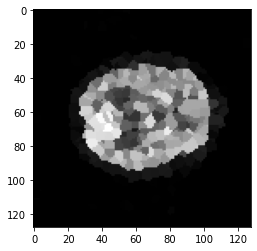

In [ ]:
plt.imshow(converted[:,:,32],cmap='gray')
plt.show()